In [1]:
import numpy as np
from numpy import linalg as la
from numpy.linalg import matrix_rank
import pandas as pd
import operator
from math import sqrt
import pandas as pd
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
%matplotlib inline

In [2]:
table = [[2,1,3,1],
         [4,1,3,4],
         [5,5,1,1],
         [2,1,3,2],
         [2,2,3,1]]

user = [2,1,4,0]

In [3]:
#aka strategy pattern implementation
class CosDistance:
    
    def distance(self,vector,vector_to_approx):
        norm_v = la.norm(vector) # if la.norm(vector) > 0 else 1 
        norm_v_approx = la.norm(vector_to_approx) #if la.norm(vector_to_approx) > 0 else 1 
        return np.dot(vector,vector_to_approx)/(norm_v*norm_v_approx)
        
class PirsonDistance:
    
    def distance(self,vector,vector_to_approx):
        vector_mean = np.mean(vector)
        vector_to_approx_mean = np.mean(vector_to_approx)
        a=0
        b=0
        c=0
        for i in range(len(vector_to_approx)):
            vector_diff = (vector[i]-vector_mean)
            vector_ap_diff = (vector_to_approx[i]-vector_to_approx_mean)
            a+= vector_diff*vector_ap_diff
            b+= vector_diff*vector_diff
            c+= vector_ap_diff*vector_ap_diff
        return a/sqrt(b*c)

def sq_score(pred_y,real_y):
    res=[]
    y_v=real_y
    yn_v=pred_y
    for i in range(len(y_v)):
        mod=abs(abs(y_v[i])-abs(yn_v[i]))
        maxim=max(y_v[i],yn_v[i])
        r=mod/maxim
        r=pow(mod/maxim,2)
        res.append(1-r)
    return np.array(res).mean()

In [4]:
class UserBasedColaborativeFiltration:
    
    def __init__(self,users,user,distance_calc=None):
        if(distance_calc==None):    
            self.distance_calc = CosDistance()
        else:
              self.distance_calc = distance_calc
        self.user = user
        self.amount_of_closest_users = 3
        self.dataset = users
        self.users = self.most_closest_users(users) 
    
    def most_closest_users(self,users):
        id_value_map = {}
        for i in range(len(users)):
            id_value_map[i]=distance_calc.distance(self.user,users[i])
        sorted_tuples = sorted(id_value_map.items(), key=operator.itemgetter(1),reverse=True)[0:self.amount_of_closest_users]
        return list(map(lambda x: users[x[0]], sorted_tuples))
    
    def predict_mark_on_item(self,item_index):
        user_mean = np.mean(self.user)
        a=0
        b=0
        for us in self.users:
            w=distance_calc.distance(self.user,us)
            a+=w*(us[item_index]-np.mean(us))
            b+=abs(w)
        return user_mean+a/b
    
    #I added this method in order to make def predict_marks() faster because if your movie unknow
    #by clothest users it returns 0 , with the help of this method you don't have to do unnecessary calculations
    def known_by_closest_users(self,index):
        know = 0
        for user in self.users:
            if(user[index]!=0):
                know+=1
        return know>0
    
    #return dictionary type {id_of_item:mark}
    def predict_marks(self):
        marks = {}
        for i,mark in enumerate(self.user):
            if(mark==0 and self.known_by_closest_users(i)):
                marks[i] = int(round(self.predict_mark_on_item(i),0))
        return marks
    
    def accuracy(self):
        R = []
        R_predicted = []
        count = 0
        more_then_max = False
        if(len(self.dataset) >100):
            more_then_max = True
        for user in self.dataset:
            self.users = self.most_closest_users(self.dataset)
            for item in range(len(user)):
                r = user[item]
                if( r != 0 ):
                    R.append(r)
                    R_predicted.append(self.predict_mark_on_item(item))
            count+=1
            if more_then_max and count >100:
                break
        R = list(map(abs,R))
        R_predicted = list(map(abs,R_predicted))
        return (mean_squared_error(R,R_predicted),mean_squared_error(R,R_predicted))#,R,R_predicted)
                
            
        
            


In [5]:
distance_calc = CosDistance()
cls = UserBasedColaborativeFiltration(table,user,distance_calc)
marks= cls.predict_marks()
print(marks)
marks= cls.predict_mark_on_item(3)
print(marks)

{3: 1}
1.1538531343882954


In [6]:
print(cls.accuracy())

(2.127831407514437, 2.127831407514437)


In [7]:
#looks like UserBasedColaborativeFiltration but with transposed data
class ItemBasedColaborativeFiltration:
    
    def __init__(self,users,user,distance_calc=None):
        if(distance_calc==None):    
            self.distance_calc = CosDistance()
        else:
              self.distance_calc = distance_calc
        self.user = user
        self.dataset = users
        self.amount_of_closest_items = 3
        self.users = users
        self.items = np.transpose(self.users)

        
    
        
    
    def most_closest_items(self,item):
        id_value_map = {}
        for i in range(len(self.items)):
            id_value_map[i]=distance_calc.distance(item,self.items[i])
        sorted_tuples = sorted(id_value_map.items(), key=operator.itemgetter(1),reverse=True)
        filtered = list(filter(lambda x: self.user[x[0]]!=0, sorted_tuples))[0:self.amount_of_closest_items]
        return list(map(lambda x: (x[0],self.items[x[0]].tolist()), filtered))
    
    def predict_mark_on_item(self,item_index):
        item = self.items[item_index]
        a=0
        b=0
        mcl = self.most_closest_items(item)
        #print(mcl)
        for it in mcl:
            #print(str(item)+":"+str(it[1]))
            w=distance_calc.distance(it[1],item)
            a+=w*self.user[it[0]]
            b+=abs(w)
           # print(str(w)+":"+str(self.user[it[0]])+":"+str(w*self.user[it[0]]))
           # print("+-----------------------------------------+")
        return a/b
        
    #return dictionary type {id_of_item:mark}
    def predict_marks(self):
        marks = {}
        for i,mark in enumerate(self.user):
            if(mark==0):
                marks[i] = int(round(self.predict_mark_on_item(i),0))
        return marks
    
    def accuracy(self):
        R = []
        R_predicted = []
        count=0
        more_then_max = False
        if(len(self.dataset) >100):
            more_then_max = True
        for user in self.dataset:
            self.user = user
            for item in range(len(user)):
                r = user[item]
                if( r != 0 ):
                    R.append(r)
                    R_predicted.append(self.predict_mark_on_item(item))
            count+=1
            if more_then_max and count >100:
                break
                
        R = list(map(abs,R))
        R_predicted = list(map(abs,R_predicted))
        return (mean_squared_error(R,R_predicted),mean_squared_error(R,R_predicted))#(sq_score(R,R_predicted))#,mean_squared_error(R,R_predicted),R,R_predicted)
    
    
    

In [8]:
distance_calc = CosDistance()
cls = ItemBasedColaborativeFiltration(table,user,distance_calc)
cls.amount_of_closest_items = 4
marks= cls.predict_marks()
print(marks)
marks= cls.predict_mark_on_item(3)
print(marks)

{3: 3}
2.5436137351675643


In [9]:
print(cls.accuracy())

(1.0940310488154021, 1.0940310488154021)


In [10]:
def load_datasets(filename):
    df = pd.read_csv(filename, delimiter=',')
    return df

def df_to_matrix(df):
    return np.transpose(df.drop('JokeId', axis=1).fillna(0).as_matrix())

def load_jokes(filename):
    result = {}
    df = pd.read_csv(filename, delimiter=',')
    for row in df.as_matrix():
        result[row[0]] = row[1]
    return result

def print_jokes_with_mark_bigger_than(jokes,marks,mark):
    for m in marks:
        if(marks[m]>mark):
            print("Mark:"+str(marks[m]))
            print("Joke id:"+str(m))
            print(jokes[m])
            print("+---------------------------------------------------------------------+")

In [11]:
filename = "UserRatings1.csv"
df = load_datasets(filename)
print(df)

    JokeId  User1  User2  User3  User4  User5  User6  User7  User8  User9  \
0        0   5.10  -8.79  -3.50   7.14  -8.79   9.22  -4.03   3.11  -3.64   
1        1   4.90  -0.87  -2.91  -3.88  -0.58   9.37  -1.55   0.92  -3.35   
2        2   1.75   1.99  -2.18  -3.06  -0.58  -3.93  -3.64   7.52  -6.46   
3        3  -4.17  -4.61  -0.10   0.05   8.98   9.27  -6.99   0.49  -3.40   
4        4   5.15   5.39   7.52   6.26   7.67   3.45   5.44  -0.58   1.26   
5        5   1.75  -0.78   1.26   6.65   8.25  -8.11  -6.75   2.14   0.34   
6        6   4.76   1.60  -5.39  -7.52   4.08   4.42  -0.15  -0.24  -3.01   
7        7   3.30   1.07   1.50   7.28   2.52   2.72  -5.87   8.06  -6.65   
8        8  -2.57  -8.69  -8.40  -5.15  -9.66   9.08  -3.54   2.82  -3.40   
9        9  -1.41  -4.66   4.37  -7.14   2.48   9.13  -5.19   7.52   1.36   
10      10   4.22   7.72   3.45  -3.06   6.89  -8.25  -3.69   3.45   0.34   
11      11   0.53   7.48  -3.20   7.67   1.36   9.03  -3.93  -3.35   4.13   

In [12]:
X = df_to_matrix(df)
f = open('text.txt', 'w')
for i in range(len(X)):
    for j in range(len(X[i])):
        if(X[i][j]!=0):
            f.write(str(i)+","+str(j)+","+str(X[i][j])+"\n")
f.close()
print(X)
print(X.shape)

[[ 5.1   4.9   1.75 ... -0.19  3.25  4.37]
 [-8.79 -0.87  1.99 ...  4.13 -1.84  2.96]
 [-3.5  -2.91 -2.18 ... -6.89 -2.33 -7.38]
 ...
 [ 0.   -1.6   0.   ...  0.    0.    0.  ]
 [ 2.91 -4.56  8.98 ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]]
(36710, 100)


In [13]:
jokes_filename = "JokeText.csv"
jokes = load_jokes(jokes_filename)
for joke in jokes:
    print("Joke number:"+str(joke))
    print(jokes[joke])
    print("+--------------------------------------+")

Joke number:0
A man visits the doctor. The doctor says "I have bad news for you.You have
cancer and Alzheimer's disease". 
The man replies "Well,thank God I don't have cancer!"

+--------------------------------------+
Joke number:1
This couple had an excellent relationship going until one day he came home
from work to find his girlfriend packing. He asked her why she was leaving him
and she told him that she had heard awful things about him. 

"What could they possibly have said to make you move out?" 

"They told me that you were a pedophile." 

He replied, "That's an awfully big word for a ten year old." 

+--------------------------------------+
Joke number:2
Q. What's 200 feet long and has 4 teeth? 

A. The front row at a Willie Nelson Concert.

+--------------------------------------+
Joke number:3
Q. What's the difference between a man and a toilet? 

A. A toilet doesn't follow you around after you use it.

+--------------------------------------+
Joke number:4
Q.	What's O. J. S

In [14]:
jokes_i_read = [0 for i in range(len(jokes))]
jokes_i_read[0] = 2
jokes_i_read[1] = 8
jokes_i_read[4] = -4
jokes_i_read[5] = -2
jokes_i_read[6] = 1
jokes_i_read[7] = 2
jokes_i_read[8] = -4
jokes_i_read[9] = -4
jokes_i_read[10] = -4
jokes_i_read[11] = -4
jokes_i_read[12] = -4
jokes_i_read[13] = -4
jokes_i_read[14] = -4
jokes_i_read[15] = -4
jokes_i_read[16] = 3
jokes_i_read[38] = 4
jokes_i_read[39] = 5
jokes_i_read[40] = 6
jokes_i_read[48] = 7
jokes_i_read[49] = 8  

In [15]:
distance_calc = CosDistance()
cls = UserBasedColaborativeFiltration(X,jokes_i_read,distance_calc)

In [16]:
mark= cls.predict_mark_on_item(3)
print(mark)

-2.2014235063484664


In [17]:
print(cls.accuracy())

(15.434936449787134, 15.434936449787134)


In [18]:
marks= cls.predict_marks()

In [19]:
print_jokes_with_mark_bigger_than(jokes,marks,5)

Mark:7
Joke id:26
Clinton returns from a vacation in Arkansas and walks down  the
steps of Air Force One with two pigs under his arms.  At the bottom
of the steps, he says  to the honor guardsman, "These are genuine
Arkansas Razor-Back Hogs.  I got this one for Chelsea and this one for
Hillary."  

The guardsman replies, "Nice trade, Sir."

+---------------------------------------------------------------------+
Mark:6
Joke id:34
An explorer in the deepest Amazon suddenly finds himself surrounded
by a bloodthirsty group of natives. Upon surveying the situation, he
says quietly to himself, "Oh God, I'm screwed." 

The sky darkens and a voice booms out, "No, you are NOT
screwed. Pick up that stone at your feet and bash in the head of the
chief standing in front of you." 

So with the stone he bashes the life out of the chief. Standing above
the lifeless body, breathing heavily looking at 100 angry natives... 

The voice booms out again, "Okay ..... NOW you're screwed." 

+----------------

In [20]:
distance_calc = CosDistance()
cls = ItemBasedColaborativeFiltration(X,jokes_i_read,distance_calc)

In [21]:
mark= cls.predict_mark_on_item(3)
print(mark)

1.7601072667016298


In [22]:
marks= cls.predict_marks()

In [23]:
#print(cls.accuracy())

In [24]:
print_jokes_with_mark_bigger_than(jokes,marks,4)

Mark:6
Joke id:20
What's the difference between a used tire and 365 used condoms?

One's a Goodyear, the other's a great year.

+---------------------------------------------------------------------+
Mark:5
Joke id:31
A man arrives at the gates of heaven. St. Peter asks, "Religion?" 
The man says, "Methodist." St. Peter looks down his list, and says, 
"Go to room 24, but be very quiet as you pass room 8." 

Another man arrives at the gates of heaven. "Religion?"
"Baptist." "Go to room 18, but be very quiet as you pass room 8." 

A third man arrives at the gates. "Religion?" "Jewish."
"Go to room 11, but be very quiet as you pass room 8." 
The man says, "I can understand there being different rooms for different religions, but why
must I be quiet when I pass room 8?" St. Peter tells him, "Well the Catholics are in room 8, 
and they think they're the only ones here.

+---------------------------------------------------------------------+
Mark:5
Joke id:67
A man piloting a hot air balloon

In [25]:
class SVD:
    
    def __init__(self,eps = 0.001 ,learning_rate = 0.05, num_iter = 30000,reg = 0.02,n_factors=1,n_print = 1000):
        self.eps = eps
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.reg = reg
        self.n_factors = n_factors
        self.n_print = n_print
        
    def fit(self, trainset):
        self.trainset =trainset
        self.global_mean = np.matrix(trainset).mean()
        self.u_n = len(trainset)
        self.i_n = len(trainset[0])
        bu = np.zeros(self.u_n, np.double)
        bi = np.zeros(self.i_n, np.double)
        
        m=0.5
        s=0.1
        
        pu = np.random.normal(m, s, [self.u_n,self.n_factors])
        qi = np.random.normal(m, s, [self.i_n,self.n_factors])
        
        cost_story =[]
        error_story = [100]
        for current_epoch in range(self.num_iter):
            for u in range(len(trainset)):
                for i in range(len(trainset[u])):
                    r = trainset[u][i]
           
                    dot = np.dot(qi[i],pu[u])
                    err = r - (self.global_mean + bu[u] + bi[i] + dot)
                    error_story.append(err)

                    bu[u] += self.learning_rate * (err - self.reg * bu[u])
                    bi[i] += self.learning_rate * (err - self.reg * bi[i])
            
                    for f in range(self.n_factors):
                        puf = pu[u, f]
                        qif = qi[i, f]
                        pu[u, f] += self.learning_rate * (err * qif - self.reg * puf)
                        qi[i, f] += self.learning_rate * (err * puf - self.reg * qif)
                        
            if abs(err - error_story[-2]) < self.eps:
                print("{}-th iteration: {}".format(current_epoch,err))
                break            
                        
            if current_epoch %  self.n_print == 0:
                print("{}-th iteration: {}".format(current_epoch,err))
                cost_story.append(abs(err))
        
        plt.plot(cost_story)
        plt.ylabel("Cost")
        plt.xlabel("Iteration, *{}".format(self.n_print))
        plt.show()
    
                    
        self.bu = bu
        self.bi = bi
        self.pu = pu
        self.qi = qi

    
    def estimate(self, u, i):

        known_user =  u in range(len(self.trainset))
        known_item =  i in range(len(self.trainset[0]))
        est = self.global_mean

        if known_user:
            est += self.bu[u]

        if known_item:
            est += self.bi[i]

        if known_user and known_item:
             est += np.dot(self.qi[i], self.pu[u])
        if not known_user or not known_item:
                print('User and item are unkown.')
                return 0

        return est
    
    def accuracy(self):
        R = []
        R_predicted = []
        for u in range(len(self.trainset)):
            for i in range(len(self.trainset[u])):
                r = self.trainset[u][i]
                if( r != 0 ):
                    R.append(r)
                    R_predicted.append(self.estimate(u,i))
        R = list(map(abs,R))
        R_predicted = list(map(abs,R_predicted))
        return (mean_squared_error(R,R_predicted),mean_squared_error(R,R_predicted))#(1-mean_squared_error(R,R_predicted),1-mean_absolute_error(R,R_predicted),sq_score(R,R_predicted))
    

0-th iteration: -2.6126823570272215
1000-th iteration: -0.06517707062200251
2000-th iteration: -0.06528426720810643
3000-th iteration: -0.06528668558431572
4000-th iteration: -0.06528673795635465
5000-th iteration: -0.06528673905275761
6000-th iteration: -0.0652867390752716
7000-th iteration: -0.06528673907572902
8000-th iteration: -0.06528673907573834
9000-th iteration: -0.06528673907573879
10000-th iteration: -0.06528673907573856
11000-th iteration: -0.06528673907573856
12000-th iteration: -0.06528673907573834
13000-th iteration: -0.06528673907573834
14000-th iteration: -0.06528673907573834
15000-th iteration: -0.06528673907573834
16000-th iteration: -0.06528673907573856
17000-th iteration: -0.06528673907573856
18000-th iteration: -0.06528673907573834
19000-th iteration: -0.06528673907573834
20000-th iteration: -0.06528673907573856
21000-th iteration: -0.0652867390757379
22000-th iteration: -0.06528673907573856
23000-th iteration: -0.06528673907573834
24000-th iteration: -0.065286739

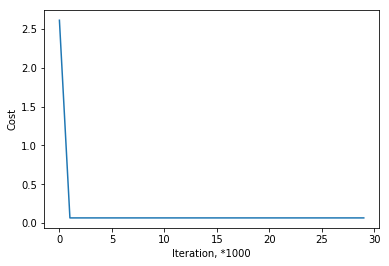

In [26]:
cls = SVD(n_factors=3)
temp = []
for vec in table:
    temp.append(vec)
temp.append(user)
cls.fit(temp)

In [27]:
print(temp)
print(temp[5][3])
print(cls.estimate(5,3))

[[2, 1, 3, 1], [4, 1, 3, 4], [5, 5, 1, 1], [2, 1, 3, 2], [2, 2, 3, 1], [2, 1, 4, 0]]
0
0.04884630638295029


In [28]:
print(cls.accuracy())

(0.0008639685920411863, 0.0008639685920411863)


100
0-th iteration: -2.0106931221713427
100-th iteration: -0.8341614330422922
200-th iteration: -0.8400602088463547
300-th iteration: -0.8693516390212999
400-th iteration: -0.8434324327115648
500-th iteration: -1.3798315104736287
600-th iteration: -0.8410110355733527
700-th iteration: -0.9595279864686657
800-th iteration: -0.8596125873523186
900-th iteration: -1.2567890608845953


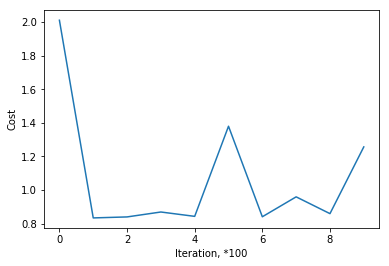

In [31]:
factors = min(np.matrix(X).shape)
print(matrix_rank(X))
cls = SVD(eps = 0.01 , num_iter = 1000,n_factors=1,n_print=100)
cls.fit(X[:1000])

In [32]:
print("acc")
print(cls.accuracy())

acc
(12.325342699155827, 12.325342699155827)
